In this notebook we validate that mutations in positions with extreme CAI/mfe scores are depleted in healthy genomes. 

The rationale - mutations in these positions are more harmful than mutations in random positions (effect on co-translational folding and translation) and so will be depleted in healthy genomes. 

We consider mutations in 1000G as "null", which is *usually* a true assumption. 
We take TCGA mutations (all snps from the CDS of all human protein coding genes) and we see the ratio of mutations (in 1000G / not in 1000G).
Then we look at the 1% with lowest/highest mfe/CAI and check the ratio. We expect this ratio to be smaller for the extreme positions. 

We also obtain a hyper-geometric p-value and an empirical p-value using randomizations. 

## Imports

In [1]:
import pandas as pd
import gzip
import concurrent.futures
import pickle
import numpy as np
from scipy.stats import hypergeom
import matplotlib.pyplot as plt

## functions

In [5]:
''' Get the z-scores and respective p-values for our current examined variant '''
def get_zscores_and_pvals(mut_info: dict, gene_protein_dict: dict, chr2cds_allgenes: dict) -> [float, float, float, float, float, float, float, float]:
    
    try:
    
        #basic info of the mutation
        mut_start = mut_info["Start_Position"] # 1-based start position, relative to the chromosome

        gene_id = mut_info["Gene"]
        protein_id = gene_protein_dict[gene_id]
        
        assert(mut_info["ENSP"] == protein_id)

        chr2cds = chr2cds_allgenes[gene_id, protein_id] #mapping chrm_pos -> cds_pos of the current gene. 0-based. 
        cds_mut_start = chr2cds[mut_start - 1] #0-based start position relative to the CDS. 
        aa_mut_start = int(np.floor(cds_mut_start / 3)) #results of CAI are in codons, not nts

        #mfe
        mfe_ver = pd.read_pickle(f"../Results/AllGenes/mfe/z-scores/{gene_id}_vertical.pickle")
        mfe_ver_zscore = mfe_ver.loc[cds_mut_start]["z-score"]
        mfe_ver_pval = mfe_ver.loc[cds_mut_start]["p-value"]

        mfe_col = pd.read_pickle(f"../Results/AllGenes/mfe/z-scores/{gene_id}_column.pickle")
        mfe_col_zscore = mfe_col.loc[cds_mut_start]["z-score"]
        mfe_col_pval = mfe_col.loc[cds_mut_start]["p-value"]

        #CAI

        cai_ver = pd.read_pickle(f"../Results/AllGenes/CAI/z-scores/{gene_id}_vertical.pickle")
        cai_ver_zscore = cai_ver.loc[aa_mut_start]["z-score"]
        cai_ver_pval = cai_ver.loc[aa_mut_start]["p-value"]

        cai_col = pd.read_pickle(f"../Results/AllGenes/CAI/z-scores/{gene_id}_column.pickle")
        cai_col_zscore = cai_col.loc[aa_mut_start]["z-score"]
        cai_col_pval = cai_col.loc[aa_mut_start]["p-value"]

        return(mfe_ver_zscore, mfe_ver_pval, mfe_col_zscore, mfe_col_pval, cai_ver_zscore, cai_ver_pval, cai_col_zscore, cai_col_pval)
    
    except:
        
        return(None, None, None, None, None, None, None, None)

In [7]:
''' we have a file with all the TCGA CDS mutations in a specific chromosome. Given the chromosome this function
retrieve this file, adds the z-scores and p-values for each of the mutations and saves only columns needed for downstream analysis in another df'''

def get_zscores_single_chromosome(chromo: str) -> None:
    
    path_tcga_muts = f"../co_trans_data/TCGA/cds_mutations_chr{chromo}.txt" #contains cds mutations of all genes on the current chromosome
    df_cur_chrom = pd.read_csv(path_tcga_muts, delimiter=',')
    
    # add the z-scores to our df
    df_partial = df_cur_chrom[["Gene", "Chromosome", "Start_Position", "End_Position", "Variant_Classification", "Reference_Allele", "Tumor_Seq_Allele2", "Transcript_ID", "ENSP", "Variant_Type"]].copy()
    df_partial[["mfe_v_z","mfe_v_p","mfe_c_z","mfe_c_p","cai_v_z","cai_v_p","cai_c_z","cai_c_p"]] = df_partial.apply(lambda x: pd.Series(get_zscores_and_pvals(x, gene_protein_dict, chr2cds_allgenes)), axis = 1)

    with open(f"../co_trans_data/TCGA/cds_mutations_chr{chromo}_with_zscores.pickle", 'wb') as handle:
        pickle.dump(df_partial, handle)


In [12]:
''' This function is a "patch". The function "get_zscores_single_chromosome" creates a smaller df that has needed info for checking
the depletion of mutations with extreme z-scores in 1000G. We are creating a few changes to this df - 
1. Keeping only snps (in the 1000G we have no variant end-position,  so we will check only snps)
2. Keeping only unique mutations. 
3. Add a column that indicates whether the mutation is in 1000G or not '''

def patch_single_chromosome(chromo:str) -> None:

    #get the df with the z-scores and info on each mut
    tcga_cur_chrom = pd.read_pickle(f"../co_trans_data/TCGA/cds_mutations_chr{chromo}_with_zscores.pickle")
    #keep only snps
    tcga_cur_chrom = tcga_cur_chrom[tcga_cur_chrom["Variant_Type"] == "SNP"].copy() #we keep only snps when comparing to 1000G currently
    #keep only unique mutations
    tcga_cur_chrom["mut_id"] = tcga_cur_chrom.apply(lambda x: x["Gene"] + ":" + x["Chromosome"] + ":" + str(x["Start_Position"]) + ":" +  
                                                    x["Variant_Classification"] + ":" + x["Reference_Allele"] + ":" + x["Tumor_Seq_Allele2"], axis = 1)
    tcga_cur_chrom = tcga_cur_chrom.drop_duplicates(subset=['mut_id'])


    #get the 1000G data of this chromosome
    thousand_genomes_cur_chrom = pd.read_pickle(f"/tamir2/lab_resources/Datasets/1000_Genomes_Project/1000G_chr{chromo}_GRCh38.pkl")
    thousand_genomes_cur_chrom = thousand_genomes_cur_chrom[thousand_genomes_cur_chrom["VT"] == "SNP"] #keep only snps

    #check whether each of our TCGA mutations is in 1000G or not
    tcga_cur_chrom["in_1000g"] = tcga_cur_chrom.apply(lambda x: in_1000G(x["Start_Position"], x["Reference_Allele"], x["Tumor_Seq_Allele2"] , thousand_genomes_cur_chrom), axis = 1)

    #save the new df
    with open(f"../co_trans_data/TCGA/cds_mutations_chr{chromo}_with_zscores_1000G.pickle", 'wb') as handle:
        pickle.dump(tcga_cur_chrom, handle)



In [9]:
''' This function checks if a specific mutation is in 1000G database or not '''
def in_1000G(start_pos: int, ref_allele: str, mut_allele: str, df_1000g: pd.DataFrame) -> bool:
    
    cur_pos_df = df_1000g[df_1000g["POS"] == start_pos].copy()

    if len(cur_pos_df) == 0:  #if "start_pos" is not on 1000g, return False.
        return(False)

    else:
        right_nucs = np.any((cur_pos_df["REF"] == ref_allele) & (cur_pos_df["ALT"] == mut_allele)) #start position is in 1000G. check if the nuc change is the same.
        #if it is the same - the mutation is in 1000G, return True. Else, return False.
        return(right_nucs)  

In [11]:
''' This function calcululates a hypergeometric p-value. 
"population_size" - how many TCGA variants are there? (in our analysis - all SNPs in the CDSs of all genes)
"total_success" - how many of these TCGA variants are *not* in 1000G ("therefore treated as "non-null")
"num_draws" - how many variants are in our "sample"? in our case, how many variants received the lowest / highest
1% of z-scores?
"observed_success" - how many of the variants in the sample are *not* in 1000G? 
'''

def calc_hg_pval(counts_df: pd.DataFrame) -> [float, float]:
    
    population_size = counts_df["Original"].sum()
    total_success = counts_df.loc[False,"Original"] 
    num_draws_low = counts_df["Percentile_low"].sum()
    num_draws_high = counts_df["Percentile_high"].sum()

    #assert(num_draws == counts_df.loc["Percentile99"].sum())
    observed_success_low = counts_df.loc[False,"Percentile_low"]
    observed_success_high = counts_df.loc[False,"Percentile_high"]

    
    hg_p_low = hypergeom.sf(observed_success_low - 1, population_size, total_success, num_draws_low)
    hg_p_high = hypergeom.sf(observed_success_high - 1, population_size, total_success, num_draws_high)
    
    return(hg_p_low, hg_p_high)

In [13]:
''' This function creates a df that counts that variant in the complete "original" dataset of TCGA variants and on the 
"sampled" datasets (TCGA variants with lowest and highest 1% z-scores for example). This df counts the amount of variants
in 1000G and not in 1000G for each of these groups. 
'''
def get_counts_per_chromosome(chromo: str, measure: str , percentiles: dict, low_perc: str, high_perc: str) -> dict:
     
    counts = {} #initiliaze dictionary to contain the results
   
    tcga_cur_chrom = pd.read_pickle(f"../co_trans_data/TCGA/cds_mutations_chr{chromo}_with_zscores_1000G.pickle") #get the data of the current chromosome
        
    counts["original"] = tcga_cur_chrom["in_1000g"].value_counts() #original ratio -> How many TCGA variants of tghis chromosome are in 1000G and how many are'nt
        
    for measure in measures:
        low_perc_counts = tcga_cur_chrom[tcga_cur_chrom[measure] <= percentiles[measure,low_perc]]["in_1000g"].value_counts() #ratio in the lowest 1st percent
        high_perc_counts = tcga_cur_chrom[tcga_cur_chrom[measure] >= percentiles[measure,high_perc]]["in_1000g"].value_counts() #ratio in the highest 1st percent
        counts[measure, "perc_low"] = low_perc_counts
        counts[measure, "perc_high"] = high_perc_counts
        
    with open(f"../co_trans_data/TCGA/1000G_value_counts_chr{chromo}_{low_perc}.pickle", 'wb') as handle:
        pickle.dump(counts, handle)

    

In [2]:
''' we want to examine whether the intersection between the two methods leads to a higher depletion '''

def counts_both_single_method(method: str, low_perc: float, high_perc: float, percentiles: dict, tcga_cur_chrom: pd.DataFrame) -> [pd.DataFrame, pd.DataFrame]:
    
    #get the variants with low and high MFE scores according to the vertical permutations
    df_low_v = tcga_cur_chrom[tcga_cur_chrom[f"{method}_v_z"] <= percentiles[f"{method}_v_z",low_perc]]
    df_high_v = tcga_cur_chrom[tcga_cur_chrom[f"{method}_v_z"] >= percentiles[f"{method}_v_z",high_perc]]
    #get the variants with low and high MFE scores according to the column permutations
    df_low_c = tcga_cur_chrom[tcga_cur_chrom[f"{method}_c_z"] <= percentiles[f"{method}_c_z",low_perc]]
    df_high_c = tcga_cur_chrom[tcga_cur_chrom[f"{method}_c_z"] >= percentiles[f"{method}_c_z",high_perc]]
    
    #get the shared variants
    low_v_mut_ids, low_c_mut_ids = list(df_low_v["mut_id"].values), list(df_low_c["mut_id"].values)
    high_v_mut_ids, high_c_mut_ids = list(df_high_v["mut_id"].values), list(df_high_c["mut_id"].values)

    low_variants = [mut_id for mut_id in low_v_mut_ids if mut_id in low_c_mut_ids]
    high_variants = [mut_id for mut_id in high_v_mut_ids if mut_id in high_c_mut_ids]
    df_low = df_low_v[df_low_v["mut_id"].isin(low_variants)].copy()
    df_high = df_high_v[df_high_v["mut_id"].isin(high_variants)].copy()
    
    low_perc_counts = df_low["in_1000g"].value_counts() #ratio in the lowest 1st percent
    high_perc_counts = df_high["in_1000g"].value_counts() #ratio in the highest 1st percent
    
    return(low_perc_counts, high_perc_counts)


In [3]:
''' Same as get_counts_per_chromosome but the high and low percent are according to the intersection of both permutations '''
def get_counts_per_chromosome_both(chromo: str, percentiles: dict, low_perc: float, high_perc: float):
     
    counts = {} #initiliaze dictionary to contain the results
   
    tcga_cur_chrom = pd.read_pickle(f"../Data/AllGenes/TCGA/cds_mutations_chr{chromo}_with_zscores_1000G.pickle") #get the data of the current chromosome
        
    counts["original"] = tcga_cur_chrom["in_1000g"].value_counts() #original ratio -> How many TCGA variants of tghis chromosome are in 1000G and how many are'nt
    for method in ["mfe", "cai"]:
        low_perc_counts,  high_perc_counts = counts_both_single_method(method, low_perc, high_perc, percentiles, tcga_cur_chrom)
        counts[method, "perc_low"] = low_perc_counts
        counts[method, "perc_high"] = high_perc_counts

    with open(f"../co_trans_data/TCGA/1000G_value_counts_chr{chromo}_{low_perc}_bothperms.pickle", 'wb') as handle:
        pickle.dump(counts, handle)
        
        


In [4]:
''' The results (how many TCGA mutations are in 1000G, from the original set and the top low_perc/high_perc percent)
are saved per chromosome. Here we combine the results '''
def get_results_all_chromosomes(measure: str, chrom_nums: list, low_perc: float, high_perc: float, both: bool) -> [pd.DataFrame, float, float]:
    
    #initilize result dfs
    original_df, low_perc_df, high_perc_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    #iterate over chromosomes and get the results per chromosome
    for chromo in chrom_nums: #no Y chromosome in our 1000G data

        if both:
            counts = pd.read_pickle(f"../co_trans_data/TCGA/1000G_value_counts_chr{chromo}_{low_perc}_bothperms.pickle")
        else:
            counts = pd.read_pickle(f"../co_trans_data/TCGA/1000G_value_counts_chr{chromo}_{low_perc}.pickle")


        orig_counts = counts["original"]
        low_perc_counts = counts[measure,"perc_low"]
        high_perc_counts = counts[measure,"perc_high"]

        #update results dfs
        original_df = pd.concat([original_df, orig_counts])
        low_perc_df = pd.concat([low_perc_df, low_perc_counts])
        high_perc_df = pd.concat([high_perc_df, high_perc_counts])

    original_df = original_df.groupby(original_df.index).sum().rename(columns={0: "Original"}) #sum the False category (not in 1000G) and True category (in 1000G) for all chromosomess
    low_perc_df = low_perc_df.groupby(low_perc_df.index).sum().rename(columns={0: "Percentile_low"})
    high_perc_df = high_perc_df.groupby(high_perc_df.index).sum().rename(columns={0: f"Percentile_high"})

    #merged, final df
    counts_df = original_df.merge(low_perc_df, left_index=True, right_index=True).merge(high_perc_df, left_index=True, right_index=True)

    #calculate hypergeometric p-value
    hg_p_low, hg_p_high = calc_hg_pval(counts_df)
        
    return(counts_df, hg_p_low, hg_p_high)

    

In [5]:
''' Here we plot the depletion '''
def bar_plot(counts_df: pd.DataFrame, hg_p_low: float, hg_p_high: float, low_perc: float, high_perc: float) -> None:
    
    ratios_df = counts_df.divide(counts_df.sum(axis=0), axis=1)
    
    group_data = np.array([
    [ratios_df.loc[False, 'Original'], ratios_df.loc[True, 'Original']],
    [ratios_df.loc[False, 'Percentile_low'], ratios_df.loc[True, 'Percentile_low']],
    [ratios_df.loc[False, 'Percentile_high'], ratios_df.loc[True, 'Percentile_high']]])

    # Calculate the null ratio and non-null ratio for each group
    non_null_ratio = group_data[:, 0] / group_data.sum(axis=1) 
    null_ratio = group_data[:, 1] / group_data.sum(axis=1) #null = in 1000G

    # Create a bar chart with stacked bars for each group
    x_labels = [f'original\n(n = {int(counts_df["Original"].sum())})', f'{low_perc} percentile\n(n = {int(counts_df["Percentile_low"].sum())})',
                f'{high_perc} percentile\n(n = {int(counts_df["Percentile_high"].sum())})']
    x_pos = np.arange(len(x_labels))

    fig, ax = plt.subplots()

    bar_width = 0.5
    
    # Plot the bars for not-nul ratio (not on 1000G)
    not_null_bars = ax.bar(x_pos, non_null_ratio, bar_width, label='Not null', color='blue')

    # Add labels for not_null ratio
    dist_from_bottom = 0.3
    for bar in not_null_bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, dist_from_bottom, f'{height:.2f}', ha='center', color='white')

    # Plot the bars for null ratio
    null_bars = ax.bar(x_pos, null_ratio, bar_width, label='Null', color='orange', bottom=non_null_ratio)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels)

    ax.set_ylabel('Ratio')
    ax.legend([not_null_bars[0], null_bars[0]], ['Not null', 'Null'])

    m = "MFE" if "mfe" in measure else "CAI"
    perm = "vertical" if "v" in measure else "column"
    
    plt.title(f"Z-scores obtained with {m}, {perm} permutations")

    plt.show()

    print(f"{low_perc}perc p-value: {hg_p_low}\n {high_perc}perc p-value: {hg_p_high}")


In [7]:
''' Here we check if a single random mutation is in 1000G or not (to create a permutation p-value) '''
def in_1000G_rand_mut(chromosome: str, ilocation: int) -> bool:
    cur_chr_mutations = pd.read_pickle(f"../co_trans_data/TCGA/cds_mutations_chr{chromosome}_with_zscores_1000G.pickle")
    in_1000g = cur_chr_mutations.iloc[ilocation]["in_1000g"]
    return(in_1000g)

In [8]:
''' We choose random groups of mutations in the same size as the group with the high percentile 
and the group with the low percentile for a fair comparison. We check how many of the mutations in
the random groups are in 1000G '''

def num_in1000G_single_random_group(chosen_low: pd.DataFrame, chosen_high: pd.DataFrame) -> [float, float]:
    
    in_1000g_rand_group_low = chosen_low.apply(lambda x: in_1000G_rand_mut(x["Chromosome"], x["ilocation"]), axis = 1)
    num_in_1000g_low = np.sum(in_1000g_rand_group_low)
    
    in_1000g_rand_group_high = chosen_high.apply(lambda x: in_1000G_rand_mut(x["Chromosome"], x["ilocation"]), axis = 1)
    num_in_1000g_high = np.sum(in_1000g_rand_group_high)
    
    return(num_in_1000g_low, num_in_1000g_high)

In [10]:
''' In this function we create "num_random_groups" randomizations and return a list of the number of mutations in 1000g in the random groups'''
def num_in1000G_all_rands(measure: str, chrom_nums: list, num_random_groups: int, low_perc: float, high_perc: float, choose_from: pd.DataFrame) -> [np.ndarray, np.ndarray]:

    #get the number of "null" mutations in the original groups
    counts_df, _, _ = get_results_all_chromosomes(measure, chrom_nums, low_perc, high_perc)
    num_muts_low, num_muts_high = int(counts_df["Percentile_low"].sum()), int(counts_df["Percentile_high"].sum())
    num_1000g_low, num_1000g_high = counts_df.loc[True, "Percentile_low"], counts_df.loc[True, "Percentile_high"]
    
    #get the number of "null" mutations in randomly chosen groups of the same size:
    num_1000g_rand_low = np.zeros(num_random_groups)
    num_1000g_rand_high = np.zeros(num_random_groups)
    
    chosens_dict = {} #cant choose randomly cocurrently because its not really random
    for i in range(num_random_groups):
        chosens_dict[i, "perc_low"] = choose_from.sample(n = num_muts_low).copy()
        chosens_dict[i, "perc_high"] = choose_from.sample(n = num_muts_high).copy()
     
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = []
        for i in range(num_random_groups):
            futures.append(executor.submit(num_in1000G_single_random_group, chosens_dict[i, "perc_low"], chosens_dict[i, "perc_high"]))

    for ind in range(num_random_groups):
        num_1000g_rand_low[ind] = futures[ind].result()[0]
        num_1000g_rand_high[ind] = futures[ind].result()[1]
        
    return(num_1000g_rand_low, num_1000g_rand_high)
        

## Main

### create a df with relevant identifying fields per mutation and its mfe & cai scores. 

In [7]:
# map the mut_start to position on the genes cds sequence
# get the z-scores and p-vals

# a dictionary that maps the gene ids to the protein ids that we used: 
gene_protein_dict = pd.read_pickle("../co_trans_data/gene_protein_dict.pickle") #map between the gene to the protein id used by ensembl

# a dictionary that maps the cds positions to the chromosome positions of our genes
chr2cds_allgenes = pd.read_pickle("../co_trans_data/chr2cds.pickle") #dictionary mapping between CDS to chromosome positions

chrom_nums = [str(i) for i in range(1, 23)] + ["X"]


In [ ]:
with concurrent.futures.ProcessPoolExecutor() as executor:
    futures = []
    for chromo in chrom_nums:
        futures.append(executor.submit(get_zscores_single_chromosome, chromo))
                      

In [43]:
with concurrent.futures.ProcessPoolExecutor() as executor:
    futures = []
    for chromo in chrom_nums:
        futures.append(executor.submit(patch_single_chromosome, chromo))
                      

### Check the if mutations in highly scored positions are depleted in 1000GP. 

Because the data is very large we keep the mutations on multiple files, according to the chromosome. However, we need to find the 1 and 99 perecentile of mfe/cai for all mutations 


In [45]:
''' Get the low and high percentile according to each measure '''

low_perc = 0.1
high_perc = 99.9

chrom_nums = [str(i) for i in range(1, 23)] + ["X"]

measures = ["mfe_v_z", "mfe_c_z", "cai_v_z", "cai_c_z"]

res = {}    

for chromo in chrom_nums: 
    #get the df with the z-scores for all mutations of this chromosome
    df_cur_chrom = pd.read_pickle(f"../co_trans_data/TCGA/cds_mutations_chr{chromo}_with_zscores_1000G.pickle")
    
    #update the dictionary with the z-scores of each measure
    for measure in measures:
        if measure in res.keys():
            res[measure].extend(df_cur_chrom[measure][~df_cur_chrom[measure].isna()])
        else:
            res[measure] = []
            res[measure].extend(df_cur_chrom[measure][~df_cur_chrom[measure].isna()])
                        
#calculate the percentiles to find the threshold for each group
percentiles = {}
for measure in measures:
    percentiles[measure, low_perc] = np.percentile(res[measure], low_perc)
    percentiles[measure, high_perc] = np.percentile(res[measure], high_perc)




In [46]:
percentiles

{('mfe_v_z', 0.1): -13.361834044823679,
 ('mfe_v_z', 99.9): 10.745456313836314,
 ('mfe_c_z', 0.1): -15.192539829317068,
 ('mfe_c_z', 99.9): 11.985549175231395,
 ('cai_v_z', 0.1): -8.059993581789634,
 ('cai_v_z', 99.9): 10.942506715059787,
 ('cai_c_z', 0.1): -15.625074587152032,
 ('cai_c_z', 99.9): 9.740779442230576}

In [36]:
''' Given the percentiles, seperate to groups and get the amount of variants in 1000G and not in 1000G '''
with concurrent.futures.ProcessPoolExecutor() as executor:
    futures = []
    for chromo in chrom_nums:
        futures.append(executor.submit(get_counts_per_chromosome, chromo, measures, percentiles, low_perc, high_perc)) 

## Plot results

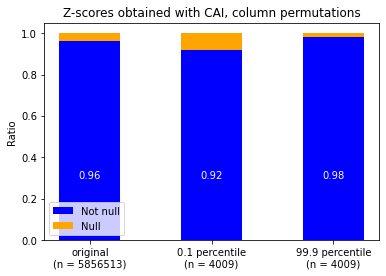

0.1perc p-value: 1.0
 99.9perc p-value: 8.675433065941836e-14


In [56]:
measure = "cai_c_z"
low_perc = 0.1
high_perc = 99.9

counts_df, hg_p_low, hg_p_high = get_results_all_chromosomes(measure, chrom_nums, low_perc, high_perc)
# note: even though we are taking the highest and lowest 1 percent, the group size in not necesarily
#exactly the same because many mutations get the same score and then the cut-off is a bit offset. 

bar_plot(counts_df, hg_p_low, hg_p_high, low_perc, high_perc)

In [60]:
''' Obtain an empirical p-value as well '''

#we need to choose randomly a group of mutations *from all chromosomes* so we will create a df with all possibilities to choose from, 
#containing both the chromosome number and the iloc of the mutation in the df of the chromosome, and choose the needed amount from that. 

chrom_nums = [str(i) for i in range(1, 23)] + ["X"]

choose_from = pd.DataFrame(columns = ["Chromosome", "ilocation"]) 

for chromo in chrom_nums:
    
    tcga_cur_chrom = pd.read_pickle(f"../co_trans_data/TCGA/cds_mutations_chr{chromo}_with_zscores_1000G.pickle") #get the data of the current chromosome
    num_muts_cur_chrom = tcga_cur_chrom.shape[0]
    iloc = np.arange(num_muts_cur_chrom)
    chromosome = [chromo] * num_muts_cur_chrom
    temp_df = pd.DataFrame()
    temp_df["Chromosome"], temp_df["ilocation"] = chromosome, iloc
    
    choose_from = pd.concat([choose_from, temp_df])
  

In [11]:
''' here we create randomizations for the group of low z-scores and high z-scores, meaning that we
take the same amount of random TCGA variants and see how many of the random group are in 1000G. 
We do this many times and thus create and empirical p-value '''

def get_emp_pval(measure: str, chrom_nums: list, num_random_groups: int, low_perc: float, high_perc: float) -> [float, float]:
    
    #get counts for randomizations
    num_1000g_rands_low, num_1000g_rands_high = num_in1000G_all_rands(measure, chrom_nums, num_random_groups, low_perc, high_perc)
    
    #get counts for the true low and high percentages
    counts_df, _, _ = get_results_all_chromosomes(measure, chrom_nums, low_perc, high_perc)
    num_muts_low, num_muts_high = int(counts_df["Percentile_low"].sum()), int(counts_df["Percentile_high"].sum())
    num_1000g_low, num_1000g_high = counts_df.loc[True, "Percentile_low"], counts_df.loc[True, "Percentile_high"]
    
    #calculate empirical pvalues
    pval_low = 1 - np.sum(num_1000g_low < num_1000g_rands_low) / num_1000g_rands_low.shape[0]
    pval_high = 1 - np.sum(num_1000g_high < num_1000g_rands_high) / num_1000g_rands_high.shape[0]
    
    return(pval_low, pval_high)


In [65]:
measure = "mfe_v_z"
num_random_groups = 100
low_perc = 0.1
high_perc = 99.9

pval_low, pval_high = get_emp_pval(measure, chrom_nums, num_random_groups, low_perc, high_perc)

with open(f"../Results/AllGenes/validation/z-scores/1000G/ampirical_pvals/{measure}_perc{low_perc}_pval.pickle", 'wb') as handle:
                pickle.dump(pval_low, handle)
        
with open(f"../Results/AllGenes/validation/z-scores/1000G/ampirical_pvals/{measure}_perc{high_perc}_pval.pickle", 'wb') as handle:
                pickle.dump(pval_high, handle)
        

## variants that are both in the bottom or top percentiles according to both permutation methods

In [48]:
chrom_nums = [str(i) for i in range(1, 23)] + ["X"]
low_perc = 0.1
high_perc = 99.9


for chromo in chrom_nums:
    get_counts_per_chromosome_both(chromo, percentiles, low_perc, high_perc)

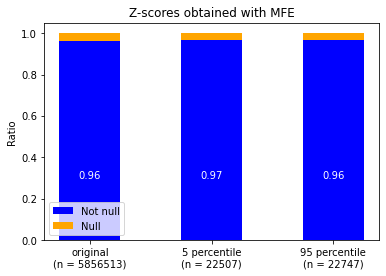

5perc p-value: 0.0016918372709773422
 95perc p-value: 0.01033072664570908


In [52]:
measure = "mfe"
low_perc = 5
high_perc = 95

counts_df, hg_p_low, hg_p_high = get_results_all_chromosomes(measure, chrom_nums, low_perc, high_perc, both = True)

bar_plot(counts_df, hg_p_low, hg_p_high, low_perc, high_perc)

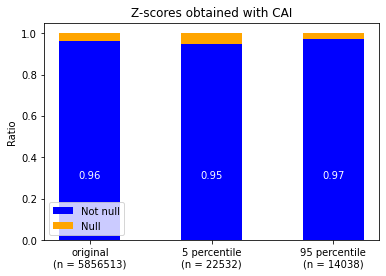

5perc p-value: 1.0
 95perc p-value: 4.309872693016674e-15


In [55]:
measure = "cai"
low_perc = 5
high_perc = 95

counts_df, hg_p_low, hg_p_high = get_results_all_chromosomes(measure, chrom_nums, low_perc, high_perc, both = True)

bar_plot(counts_df, hg_p_low, hg_p_high, low_perc, high_perc)

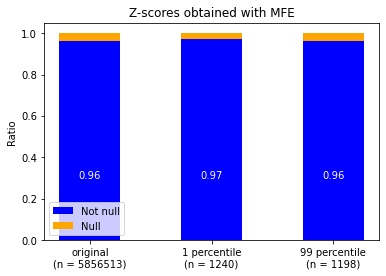

1perc p-value: 0.0917057422526707
 99perc p-value: 0.37534496833242725


In [53]:
measure = "mfe"
low_perc = 1
high_perc = 99

counts_df, hg_p_low, hg_p_high = get_results_all_chromosomes(measure, chrom_nums, low_perc, high_perc, both = True)

bar_plot(counts_df, hg_p_low, hg_p_high, low_perc, high_perc)

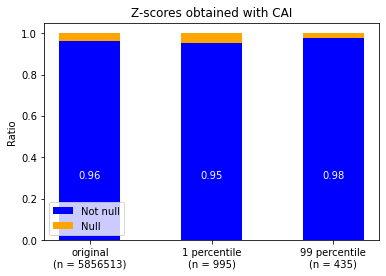

1perc p-value: 0.9548110938693073
 99perc p-value: 0.05542839400123222


In [56]:
measure = "cai"
low_perc = 1
high_perc = 99

counts_df, hg_p_low, hg_p_high = get_results_all_chromosomes(measure, chrom_nums, low_perc, high_perc, both = True)

bar_plot(counts_df, hg_p_low, hg_p_high, low_perc, high_perc)